---
# Cairo University Faculty of Engineering
## Deep Learning
## Assignment 2

---

Please write your full name here
- **Name** : Yousef Kadry

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import pandas as pd
import math

from sklearn.datasets import make_blobs  #To generate artificial data
from keras.optimizers import SGD
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

**Use TensorFlow unless mentioned otherwise**

# Part 2: Regression

In this part, (**we will implement the entire linear regression method from scratch,
including the data pipeline, the model,
the loss function, and the minibatch stochastic gradient descent optimizer.**)
You will rely only on tensors and auto differentiation.


we will use $n$ to denote
the number of examples in our dataset.
We index the data examples by $i$, denoting each input
as $\mathbf{x}^{(i)} = [x_1^{(i)}, x_2^{(i)}]^\top$
and the corresponding label as $y^{(i)}$.


**Linear Model**


We will often find it convenient
to refer to features of our entire dataset of $n$ examples
via the *design matrix* $\mathbf{X} \in \mathbb{R}^{n \times d}$.
Here, $\mathbf{X}$ contains one row for every example
and one column for every feature.

For a collection of features $\mathbf{X}$,
the predictions $\hat{\mathbf{y}} \in \mathbb{R}^n$
can be expressed via the matrix-vector product:

$${\hat{\mathbf{y}}} = \mathbf{X} \mathbf{w} + b,$$


**Loss Function**

The most popular loss function in regression problems
is the squared error.
When our prediction for an example $i$ is $\hat{y}^{(i)}$
and the corresponding true label is $y^{(i)}$,
the squared error is given by:

$$l^{(i)}(\mathbf{w}, b) = \frac{1}{2} \left(\hat{y}^{(i)} - y^{(i)}\right)^2.$$


A regression problem for a one-dimensional case is shown below:

<img src="https://i.ibb.co/8cXVC31/fit-linreg.png" alt="fit-linreg" border="0">

To measure the quality of a model on the entire dataset of $n$ examples,
we simply average (or equivalently, sum)
the losses on the training set.

$$L(\mathbf{w}, b) =\frac{1}{n}\sum_{i=1}^n l^{(i)}(\mathbf{w}, b) =\frac{1}{n} \sum_{i=1}^n \frac{1}{2}\left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)^2.$$

When training the model, we want to find parameters ($\mathbf{w}^*, b^*$)
that minimize the total loss across all training examples:

$$\mathbf{w}^*, b^* = \operatorname*{argmin}_{\mathbf{w}, b}\  L(\mathbf{w}, b).$$


**Minibatch Stochastic Gradient Descent**


The key technique for optimizing models
consists of iteratively reducing the error
by updating the parameters in the direction
that incrementally lowers the loss function --> *gradient descent*.

We will settle for sampling a random minibatch of examples
every time we need to compute the update --> *minibatch stochastic gradient descent*.

We can express the update mathematically as follows
($\partial$ denotes the partial derivative):

$$(\mathbf{w},b) \leftarrow (\mathbf{w},b) - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_{(\mathbf{w},b)} l^{(i)}(\mathbf{w},b).$$


## Synthetic Data, Simple Model
### Generating the Dataset

To keep things simple, we will [**construct an artificial dataset
according to a linear model with additive noise.**]

In the following code snippet, we generate a dataset
containing 1000 examples, each consisting of 2 features
sampled from a standard normal distribution.
Thus our synthetic dataset will be a matrix
$\mathbf{X}\in \mathbb{R}^{1000 \times 2}$.

(**The true parameters generating our dataset will be
$\mathbf{w} = [2, -3.4]^\top$ and $b = 4.2$,
and**) our synthetic labels will be assigned according
to the following linear model with the noise term $\epsilon$:

(**$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon.$$**)

In [2]:
def synthetic_data(w, b, num_examples):
    """Generate y = Xw + b + noise."""
    X = tf.zeros((num_examples, w.shape[0]))
    X += tf.random.normal(shape=X.shape)
    y = tf.matmul(X, tf.reshape(w, (-1, 1))) + b
    y += tf.random.normal(shape=y.shape, stddev=0.01)
    y = tf.reshape(y, (-1, 1))
    return X, y

In [3]:
tf.random.set_seed(5)
true_w = tf.constant([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [4]:
print('features:', features[0],'\nlabel:', labels[0])

features: tf.Tensor([-0.18030666 -0.95028627], shape=(2,), dtype=float32) 
label: tf.Tensor([7.0726256], shape=(1,), dtype=float32)


By generating a scatter plot using the second feature `features[:, 1]` and `labels`,
we can clearly observe the linear correlation between the two.


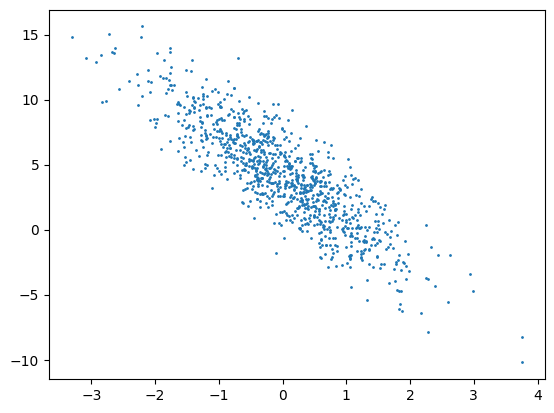

In [5]:
# The semicolon is for displaying the plot only
plt.scatter(features[:, (1)].numpy(), labels.numpy(), 1);

### Reading the Dataset

In the following code [**call upon the existing API in a framework to read data.**]
We pass in `features` and `labels` as arguments and specify `batch_size`
when instantiating a data iterator object.
Besides, the boolean value `is_train`
indicates whether or not
we want the data iterator object to shuffle the data
on each epoch (pass through the dataset).


1. **Use the tf function from_tensor_slices to generate a tf dataset object with batch_size as input**
2. **Use is_train flag to determine whether to shuffle the dataset or not, set the buffer size appropriately**

In [6]:
def load_array(data_arrays, batch_size, is_train=True):
    """Construct a TensorFlow data iterator."""
    #### YOUR CODE HERE ###
    dataset = tf.data.Dataset.from_tensor_slices(data_arrays).batch(batch_size)
    if is_train:
      dataset = dataset.shuffle(len(data_arrays[1]))

    return dataset

In [7]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)

3. **Use `iter` to construct a Python iterator and use `next` to obtain the first item from the iterator.**


In [8]:
### YOUR CODE HERE ###
iterator = iter(data_iter)
first_item = next(iterator)
first_item

(<tf.Tensor: shape=(10, 2), dtype=float32, numpy=
 array([[ 1.3564043e+00, -5.4133570e-01],
        [-1.0421329e+00,  2.0101453e-01],
        [-5.7323533e-01,  9.6179819e-01],
        [ 9.9003541e-01, -1.0166390e+00],
        [-2.7223310e-01, -4.9159122e-01],
        [-8.1928289e-01, -9.0086297e-04],
        [-2.0796096e+00,  8.4328723e-01],
        [ 3.0477965e-01,  2.0460723e-01],
        [ 1.1995399e+00,  2.9454825e+00],
        [-5.4580241e-01, -6.5089208e-01]], dtype=float32)>,
 <tf.Tensor: shape=(10, 1), dtype=float32, numpy=
 array([[ 8.755783  ],
        [ 1.4219627 ],
        [-0.21046317],
        [ 9.629394  ],
        [ 5.3383512 ],
        [ 2.5792086 ],
        [-2.8150222 ],
        [ 4.1173363 ],
        [-3.4104102 ],
        [ 5.3102717 ]], dtype=float32)>)

4. **Explain what the output shape in the prvious tensors means:**


**Answer:** the output feature shape is(10, 2) as our batch size is 10 and number of features is 2. as the same, the output label is (1, 10) as we have 1 output per instant.


5. **How many batches are in the **ENTIRE** data_iter ?**

**Answer:**

### Initializing Model Parameters

6. **Initialize weights by sampling random numbers from a normal distribution with mean 0 and a standard deviation of 0.02, and setting the bias to 0.**

Note: For the shapes of the weights and bias, look at the generating a dataset part


In [9]:
## YOUR CODE HERE ##
weights = tf.Variable(tf.random.normal(shape=(2, 1), mean=0.0, stddev=0.02))
bias = tf.Variable(tf.zeros(shape=(1,)))

print(f'weights = {weights.value},  bias = {bias.value}')

weights = <bound method BaseResourceVariable.value of <tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[0.00074006],
       [0.00691857]], dtype=float32)>>,  bias = <bound method BaseResourceVariable.value of <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>>


### Defining the Model

7. [**define our model, relating its inputs and parameters to its outputs.**]

In [10]:
def linreg(X, w, b):
    """
    The linear regression model.
    Input:
    - X: input matrix
    - w: weights
    - bias
    """
    ## YOUR CODE HERE ##
    y_hat = tf.matmul(X, w) + b
    return y_hat

### Defining the Loss Function

8. (**define the loss function**): the squared loss function
as described in Loss Function definition above.

Note: In the implementation, you need to transform the true value `y`
into the predicted value's shape `y_hat`.
The result returned by the following function
will also have the same shape as `y_hat`.


In [11]:
def squared_loss(y_hat, y):
    """Squared loss."""
    ## YOUR CODE HERE ##
    loss = tf.reduce_mean(tf.square(y_hat - y))
    return loss

### Defining the Optimization Algorithm

At each step, using one minibatch randomly drawn from our dataset,
we will estimate the gradient of the loss with respect to our parameters.
Next, we will update our parameters
in the direction that may reduce the loss.

9. **Filll in the missing function below to apply the minibatch stochastic gradient descent update, given a set of parameters, a learning rate, and a batch size.**

This function should return nothing

Note: use assign_sub


In [12]:
def sgd(params, grads, lr, batch_size):
    """Minibatch stochastic gradient descent."""
    ## YOUR CODE HERE ##
    updates = []
    for param, grad in zip(params, grads):
        updates.append(param - (lr * grad / batch_size))

    return tf.Variable(updates)


### Training

10. **Implement the following loop**

* For each epoch :
    * For each batch in data_iter:
        * Compute the loss
        * Compute gradient
        * Update parameters
    * Calculate and print the training loss at the end of each epoch



Loss = $ l({x}, {y}) $

Gradient => $\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$

Parameters update => $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$

In each *epoch*,
we will iterate through the entire dataset
(using the `data_iter` function) once
passing through every example in the training dataset
.

Don't forget to use GradientTape

Set the number of epochs `num_epochs` and the learning rate `lr` to 5 and 0.02, respectively.

In [13]:
lr = 0.02
num_epochs = 5
net = linreg
loss = squared_loss

In [14]:
## YOUR CODE HERE ## The loop code
for epoch in range(num_epochs):
    for batch_X, batch_y in data_iter:
        with tf.GradientTape() as tape:
            y_hat = net(batch_X, weights, bias)
            loss = squared_loss(y_hat, batch_y)
        gradients = tape.gradient(loss, (weights, bias))
        weights = sgd(weights, gradients[0], lr, batch_size)
        bias = sgd(bias, gradients[1], lr, batch_size)

    total_loss = 0
    for batch_X, batch_y in data_iter:
        y_hat = net(batch_X, weights, bias)
        total_loss += squared_loss(y_hat, batch_y)

    avg_epoch_loss = total_loss / len(data_iter)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_epoch_loss.numpy()}')


Epoch [1/5], Loss: 14.693944931030273
Epoch [2/5], Loss: 6.8880205154418945
Epoch [3/5], Loss: 3.236795425415039
Epoch [4/5], Loss: 1.5245733261108398
Epoch [5/5], Loss: 0.7197533249855042


In this case, because we synthesized the dataset ourselves,
we know precisely what the true parameters are.

11. [**evaluate our success in training by comparing the true parameters with those that we learned through our training loop**] (final w, b). They should turn out to be very close to each other.

calculate the difference!!


In [15]:
## YOUR CODE HERE ##
print(f'error in estimating w: {tf.subtract(true_w, tf.reshape(weights, true_w.shape))}')
print(f'error in estimating b: {tf.subtract(true_b, bias)}')

error in estimating w: [ 0.3979472  -0.50489783]
error in estimating b: [0.59945107]


## Diabetes Dataset

In this section, we will use SKLEARN's Diabetes dataset

### Loading the Dataset

1. **Load the Diabetes dataset from sklearn**

In [16]:
from sklearn.datasets import load_diabetes
## YOUR CODE HERE ##
# Load the diabetes dataset
diabetes = load_diabetes()


2. **Look at the keys of diabetes_dataset dictionary**

In [17]:
## YOUR CODE HERE ##

### Look at keys to determine the data
keys = diabetes.keys()
keys


dict_keys(['data', 'target', 'frame', 'DESCR', 'feature_names', 'data_filename', 'target_filename', 'data_module'])

3. **Use the key DESCR to understand the dataset**

In [18]:
## YOUR CODE HERE ##
diabetes.DESCR

'.. _diabetes_dataset:\n\nDiabetes dataset\n----------------\n\nTen baseline variables, age, sex, body mass index, average blood\npressure, and six blood serum measurements were obtained for each of n =\n442 diabetes patients, as well as the response of interest, a\nquantitative measure of disease progression one year after baseline.\n\n**Data Set Characteristics:**\n\n  :Number of Instances: 442\n\n  :Number of Attributes: First 10 columns are numeric predictive values\n\n  :Target: Column 11 is a quantitative measure of disease progression one year after baseline\n\n  :Attribute Information:\n      - age     age in years\n      - sex\n      - bmi     body mass index\n      - bp      average blood pressure\n      - s1      tc, total serum cholesterol\n      - s2      ldl, low-density lipoproteins\n      - s3      hdl, high-density lipoproteins\n      - s4      tch, total cholesterol / HDL\n      - s5      ltg, possibly log of serum triglycerides level\n      - s6      glu, blood sugar

4. **Save the data and target variables in numpy arrays and print their shapes**

In [19]:
### START CODE HERE ### (≈ 2 lines of code)
data = diabetes.data
targets = diabetes.target
### END CODE HERE ###

print ('The shape of data is: ' + str(data.shape))
print ('The shape of targets is: ' + str(targets.shape))
print ('I have f = %d features!' % (data.shape[1]))
print ('I have m = %d examples!' % (data.shape[0]))

The shape of data is: (442, 10)
The shape of targets is: (442,)
I have f = 10 features!
I have m = 442 examples!


5. **What are the ranges of each column in features and the target column?**
    - *Hint* you might find it helpful to convert to pandas dataframe and use ".describe"

In [20]:
### START CODE HERE ###
import pandas as pd
combined_data = []
combined_data = np.hstack((data, targets.reshape(-1, 1)))
columns = diabetes.feature_names
columns.append('targets')
combined_data = pd.DataFrame(combined_data, columns=columns)
combined_data.describe()


### END CODE HERE ###

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,targets
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,442.000000
mean,-2.511817e-19,1.230790e-17,-2.245564e-16,-4.797570e-17,-1.381499e-17,3.918434e-17,-5.777179e-18,-9.042540e-18,9.293722e-17,1.130318e-17,152.133484
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,77.093005
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123988e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260971e-01,-1.377672e-01,25.000000
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665608e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324559e-02,-3.317903e-02,87.000000
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670422e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947171e-03,-1.077698e-03,140.500000
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564379e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243232e-02,2.791705e-02,211.500000
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320436e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335973e-01,1.356118e-01,346.000000


### Preparing the data

6. **Split the data into train and test set using sklearn train_test_split.** Have the test set as 10% of data

In [21]:
np.random.seed(0)
### START CODE HERE ###
# Split the data into train and test sets
from sklearn.model_selection import train_test_split

train_data, test_data, train_targets, test_targets = train_test_split(diabetes.data, diabetes.target, test_size=0.1, random_state=42)

### END CODE HERE ###

print("Shape of training data is", train_data.shape)
print("Shape of training targets is", train_targets.shape)
print("Shape of test data is", test_data.shape)
print("Shape of test targets is", test_targets.shape)

Shape of training data is (397, 10)
Shape of training targets is (397,)
Shape of test data is (45, 10)
Shape of test targets is (45,)


- *feature-wise normalization*: for each feature in the input data (a column in the input data matrix), we subtract the mean of the feature and divide by the standard deviation, so that the feature is centered around 0 and has a unit standard deviation. This is easily done in NumPy.
- **Question:** Should we normalize features? WHY?
    - ANSWER: yes, to ahcive faster convergence and avoiding problems shuch as vanishing or exploading of gradients.

7. **normalize the targets**

In [22]:
### START CODE HERE ### (≈ 6 lines of code)
mean = np.mean(train_targets)
std = np.std(train_targets)
train_targets = (train_targets - mean) / std
test_targets = (test_targets - mean) / std



### END CODE HERE ###

### Building your model

7. **Use tf.keras.Sequential to build a model with:**
    - 6 hidden layers each having 128 neurons and relu activation.
    - 1 output layer
    - use input_shape argument to specify input size in 1st layer
- **Question:** How many neurons should be in output layer? What should be the activation?
    - ANSWER: 1 neuron - linear as it is regression problem

In [23]:
def build_model(input_shape):
    ### START CODE HERE ### ()

    model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=input_shape),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
    ])

    return model

In [24]:
# Print the model summary
input_shape = train_data[0].shape
input_shape
model = build_model(input_shape)
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 10)                0         
                                                                 
 dense (Dense)               (None, 128)               1408      
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 128)               1

8. **Compile the model using optimizer=Adam, loss=mean squared loss, metrics=mean absoluute error:**

In [25]:
### START CODE HERE ### ()
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])



Note that we compile the model with the mse loss function—mean squared error, the
square of the difference between the predictions and the targets. We’re also monitoring a new metric during training: mean absolute error (MAE). It’s the
absolute value of the difference between the predictions and the targets.

9. **FIT the model using for 110 epochs, 64 batch size and a validation split of 0.1**

In [26]:
### START CODE HERE ### ()
history = model.fit(train_data, train_targets, epochs=110, batch_size=64, validation_split=0.1)

Epoch 1/110


6/6 [==============================] - 1s 45ms/step - loss: 0.9922 - mean_absolute_error: 0.8535 - val_loss: 0.8745 - val_mean_absolute_error: 0.7761
Epoch 2/110
6/6 [==============================] - 0s 8ms/step - loss: 0.9065 - mean_absolute_error: 0.8233 - val_loss: 0.7653 - val_mean_absolute_error: 0.7453
Epoch 3/110
6/6 [==============================] - 0s 8ms/step - loss: 0.7353 - mean_absolute_error: 0.7409 - val_loss: 0.6560 - val_mean_absolute_error: 0.6808
Epoch 4/110
6/6 [==============================] - 0s 9ms/step - loss: 0.5821 - mean_absolute_error: 0.6421 - val_loss: 0.6789 - val_mean_absolute_error: 0.6489
Epoch 5/110
6/6 [==============================] - 0s 8ms/step - loss: 0.5465 - mean_absolute_error: 0.6051 - val_loss: 0.6281 - val_mean_absolute_error: 0.6169
Epoch 6/110
6/6 [==============================] - 0s 8ms/step - loss: 0.5425 - mean_absolute_error: 0.6004 - val_loss: 0.5870 - val_mean_absolute_error: 0.6372
Epoch 7/110
6/6 [============================

In [27]:
# Evaluate the model on the test set

test_loss, test_mae = model.evaluate(test_data, test_targets)

print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")




2/2 [==============================] - 0s 4ms/step - loss: 0.8264 - mean_absolute_error: 0.6508
Test Loss: 0.8263607621192932
Test MAE: 0.6508191227912903


In [28]:
history.history.keys()

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

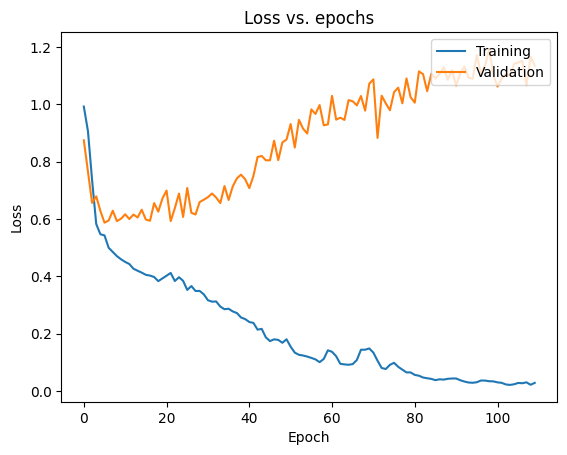

In [29]:
# Plot the training and validation loss

plt.plot(history.epoch, history.history['loss'])
plt.plot(history.epoch, history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

9. **Diagnose the learning curve:**
    - Why is the validation loss much higher than training loss?
    - What's this phenomenon called?
    - Mention 3 methods to reduce this.

- **answer**:
    - i think it is because of model Complexity and the big number of epochs that allows fitting noise 
    - overfitting
    - Early Stopping - Regularization - Simplifying Model Architecture

10. **Use one of the methods you mentioned and retrain the model then plot the learning curves**

In [31]:
model2 = build_model(input_shape)
print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 10)                0         
                                                                 
 dense_7 (Dense)             (None, 128)               1408      
                                                                 
 dense_8 (Dense)             (None, 128)               16512     
                                                                 
 dense_9 (Dense)             (None, 128)               16512     
                                                                 
 dense_10 (Dense)            (None, 128)               16512     
                                                                 
 dense_11 (Dense)            (None, 128)               16512     
                                                                 
 dense_12 (Dense)            (None, 128)              

In [32]:
model2.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])


In [33]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)  
history2 = model2.fit(train_data, train_targets, epochs=110, batch_size=64, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/110


6/6 [==============================] - 1s 39ms/step - loss: 0.9954 - mean_absolute_error: 0.8521 - val_loss: 0.8528 - val_mean_absolute_error: 0.7548
Epoch 2/110
6/6 [==============================] - 0s 9ms/step - loss: 0.8898 - mean_absolute_error: 0.8051 - val_loss: 0.7074 - val_mean_absolute_error: 0.6950
Epoch 3/110
6/6 [==============================] - 0s 9ms/step - loss: 0.6824 - mean_absolute_error: 0.6908 - val_loss: 0.6545 - val_mean_absolute_error: 0.6371
Epoch 4/110
6/6 [==============================] - 0s 10ms/step - loss: 0.5689 - mean_absolute_error: 0.6120 - val_loss: 0.5995 - val_mean_absolute_error: 0.6212
Epoch 5/110
6/6 [==============================] - 0s 9ms/step - loss: 0.5039 - mean_absolute_error: 0.5791 - val_loss: 0.5816 - val_mean_absolute_error: 0.6332
Epoch 6/110
6/6 [==============================] - 0s 8ms/step - loss: 0.4913 - mean_absolute_error: 0.5666 - val_loss: 0.5876 - val_mean_absolute_error: 0.6105
Epoch 7/110
6/6 [===========================

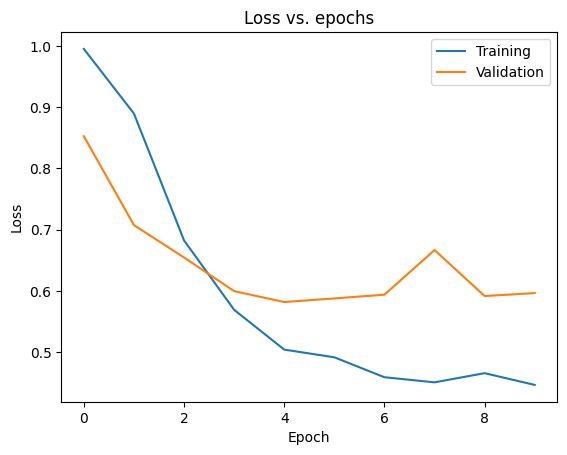

In [34]:
plt.plot(history2.epoch, history2.history['loss'])
plt.plot(history2.epoch, history2.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

# Part 3 Batches and Epochs

In this part of the assignment we will create a synthetic data to play with.
The data will have 2 features and 3 target classes --> multiclass classification problem

In [35]:
# prepare train and test dataset
def prepare_data():
    #  generate classification dataset with 3 centers (labels/classes)
    X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)

    # plot data
    for class_value in range(3):
        # select indices of points with the class label
        row_ix = np.where(y == class_value)
        # scatter plot for points with a different color
        plt.scatter(X[row_ix, 0], X[row_ix, 1])
    # show plot
    plt.show()

    # one hot encode output variable to convert from integers to binary class
    y = to_categorical(y)

    # split into train and test
    n_train = 500
    X_train, X_test = X[:n_train, :], X[n_train:, :]
    y_train, y_test = y[:n_train], y[n_train:]
    return X_train, y_train, X_test, y_test


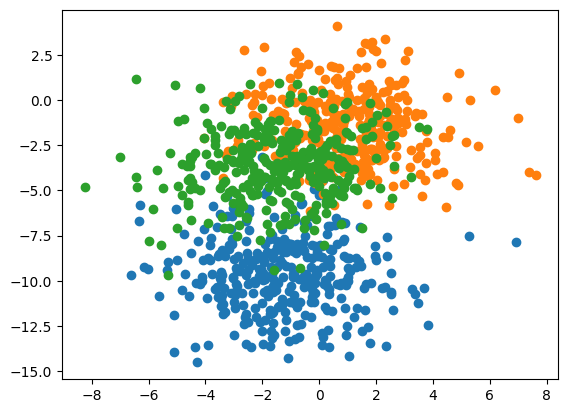

In [36]:
# prepare dataset
X_train, y_train, X_test, y_test = prepare_data()


- **Create a model with:**
    -  1 hidden dense layer (50 neurons), activation relu, , kernel_initializer he_uniform
    - 1 output layer
    - compile the model with SGD (learning rate 0.01 and momentum 0.9) optimizer and categorical crossentropy and accuracy inside build function

In [50]:
def build_model():

    ##### YOUR CODE HERE
    model = tf.keras.models.Sequential()   
    model.add(tf.keras.layers.Dense(50, activation='relu', kernel_initializer='he_uniform', input_shape=(2,)))
    model.add(tf.keras.layers.Dense(3, activation='softmax'))
    sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [43]:
model3 = build_model()

- Create a function to fit and build the model with different batch sizes

Use epochs = 125

In [44]:
# fit a model and plot learning curve
def fit_model(model, X_train, y_train, X_test, y_test, n_batch):
    ##### YOUR CODE HERE
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=125, batch_size=n_batch, verbose=2)

    return history

    

### Hyperparameter Tuning

#### Batch size

##### Size =  1

10. **train for 1 batch size**

In [48]:
### START CODE HERE ###
history = fit_model(model3, X_train, y_train, X_test, y_test, 1)
###### END CODE HERE

Epoch 1/125


500/500 - 1s - loss: 0.9342 - accuracy: 0.5600 - val_loss: 0.8745 - val_accuracy: 0.5180 - 1s/epoch - 2ms/step
Epoch 2/125
500/500 - 1s - loss: 0.9071 - accuracy: 0.5640 - val_loss: 0.8709 - val_accuracy: 0.6020 - 939ms/epoch - 2ms/step
Epoch 3/125
500/500 - 1s - loss: 0.8657 - accuracy: 0.6020 - val_loss: 0.8732 - val_accuracy: 0.5960 - 920ms/epoch - 2ms/step
Epoch 4/125
500/500 - 1s - loss: 0.9502 - accuracy: 0.5340 - val_loss: 0.9724 - val_accuracy: 0.5580 - 940ms/epoch - 2ms/step
Epoch 5/125
500/500 - 1s - loss: 0.9159 - accuracy: 0.5900 - val_loss: 0.9200 - val_accuracy: 0.6000 - 920ms/epoch - 2ms/step
Epoch 6/125
500/500 - 1s - loss: 0.8993 - accuracy: 0.6200 - val_loss: 1.0164 - val_accuracy: 0.5020 - 907ms/epoch - 2ms/step
Epoch 7/125
500/500 - 1s - loss: 0.8782 - accuracy: 0.5600 - val_loss: 0.9293 - val_accuracy: 0.5340 - 978ms/epoch - 2ms/step
Epoch 8/125
500/500 - 1s - loss: 0.9250 - accuracy: 0.5560 - val_loss: 0.9665 - val_accuracy: 0.5040 - 919ms/epoch - 2ms/step
Epoch 9

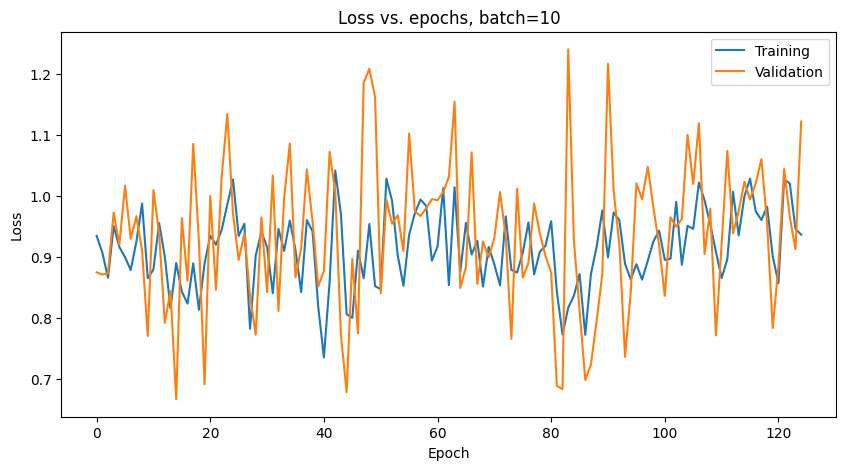

In [49]:
plt.figure(figsize=(10,5))
plt.plot(history.epoch, history.history['loss'])
plt.plot(history.epoch, history.history['val_loss'])
plt.title('Loss vs. epochs, batch=' +str(batch_size))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

- **Diagnose this curve w.r.t learning rate**:
    - ANSWER: from the curve the erorr is ossclating around some value this means the learning rate value is to big
- Change learning rate to make this curve better

In [ ]:
### Your answer

In [58]:
def build_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(50, activation='relu', kernel_initializer='he_uniform', input_shape=(2,)))  
    model.add(tf.keras.layers.Dense(3, activation='softmax'))   
    sgd = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [59]:
model4 = build_model()

Epoch 1/125


500/500 - 1s - loss: 3.0855 - accuracy: 0.5380 - val_loss: 1.2292 - val_accuracy: 0.6840 - 1s/epoch - 3ms/step
Epoch 2/125
500/500 - 1s - loss: 1.0718 - accuracy: 0.6840 - val_loss: 0.5940 - val_accuracy: 0.7900 - 982ms/epoch - 2ms/step
Epoch 3/125
500/500 - 1s - loss: 0.7508 - accuracy: 0.7160 - val_loss: 0.6689 - val_accuracy: 0.7480 - 927ms/epoch - 2ms/step
Epoch 4/125
500/500 - 1s - loss: 0.5958 - accuracy: 0.7280 - val_loss: 0.5677 - val_accuracy: 0.7580 - 934ms/epoch - 2ms/step
Epoch 5/125
500/500 - 1s - loss: 0.5596 - accuracy: 0.7540 - val_loss: 0.4559 - val_accuracy: 0.8220 - 948ms/epoch - 2ms/step
Epoch 6/125
500/500 - 1s - loss: 0.4906 - accuracy: 0.7960 - val_loss: 0.4133 - val_accuracy: 0.8300 - 876ms/epoch - 2ms/step
Epoch 7/125
500/500 - 1s - loss: 0.4815 - accuracy: 0.7920 - val_loss: 0.4416 - val_accuracy: 0.8180 - 988ms/epoch - 2ms/step
Epoch 8/125
500/500 - 1s - loss: 0.4892 - accuracy: 0.7880 - val_loss: 0.5141 - val_accuracy: 0.8200 - 1s/epoch - 2ms/step
Epoch 9/12

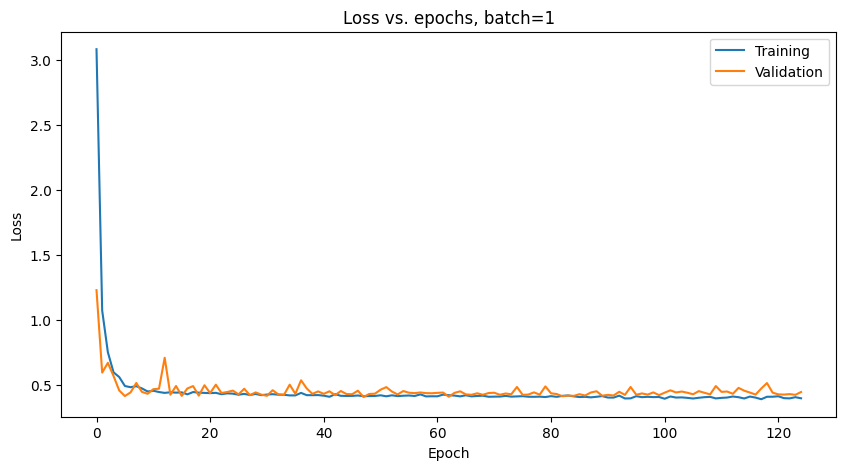

In [60]:
batch_size = 1
history = fit_model(model4, X_train, y_train, X_test, y_test, batch_size)
plt.figure(figsize=(10,5))
plt.plot(history.epoch, history.history['loss'])
plt.plot(history.epoch, history.history['val_loss'])
plt.title('Loss vs. epochs, batch=' +str(batch_size))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

##### Size =  16

10. **Retrain for 16 batch size**

In [66]:
### START CODE HERE ###
model4 = build_model()
history = fit_model(model4, X_train, y_train, X_test, y_test, 16)
###### END CODE HERE

Epoch 1/125
32/32 - 1s - loss: 1.8255 - accuracy: 0.4740 - val_loss: 0.8313 - val_accuracy: 0.6680 - 506ms/epoch - 16ms/step
Epoch 2/125
32/32 - 0s - loss: 0.9833 - accuracy: 0.5780 - val_loss: 1.2122 - val_accuracy: 0.5640 - 86ms/epoch - 3ms/step
Epoch 3/125
32/32 - 0s - loss: 0.9071 - accuracy: 0.5960 - val_loss: 0.6482 - val_accuracy: 0.6780 - 87ms/epoch - 3ms/step
Epoch 4/125
32/32 - 0s - loss: 0.7358 - accuracy: 0.6560 - val_loss: 0.6388 - val_accuracy: 0.7460 - 89ms/epoch - 3ms/step
Epoch 5/125
32/32 - 0s - loss: 0.6888 - accuracy: 0.6720 - val_loss: 0.6615 - val_accuracy: 0.6920 - 89ms/epoch - 3ms/step
Epoch 6/125
32/32 - 0s - loss: 0.6824 - accuracy: 0.6720 - val_loss: 0.6874 - val_accuracy: 0.6880 - 93ms/epoch - 3ms/step
Epoch 7/125
32/32 - 0s - loss: 0.7084 - accuracy: 0.6760 - val_loss: 0.6515 - val_accuracy: 0.6720 - 91ms/epoch - 3ms/step
Epoch 8/125
32/32 - 0s - loss: 0.6701 - accuracy: 0.6700 - val_loss: 0.6220 - val_accuracy: 0.7280 - 93ms/epoch - 3ms/step
Epoch 9/125
32

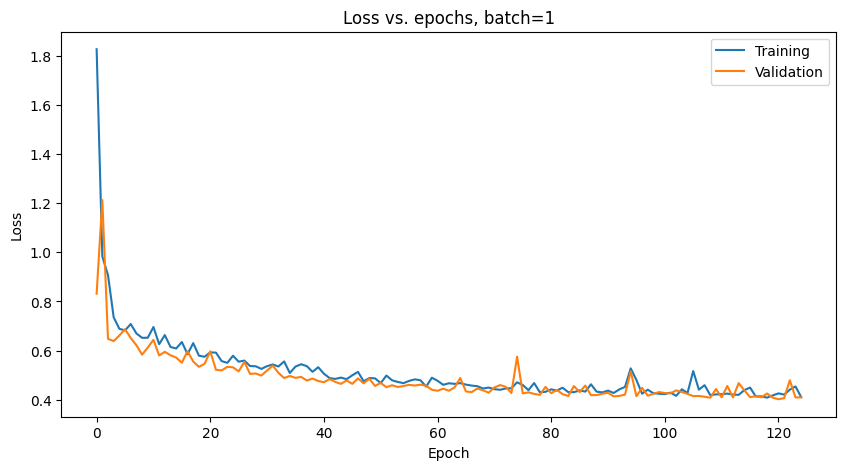

In [67]:
plt.figure(figsize=(10,5))
plt.plot(history.epoch, history.history['loss'])
plt.plot(history.epoch, history.history['val_loss'])
plt.title('Loss vs. epochs, batch=' +str(batch_size))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

##### Size =  128

10. **Retrain for 128 batch size**

In [68]:
### START CODE HERE ###
model4 = build_model()
history = fit_model(model4, X_train, y_train, X_test, y_test, 128)

###### END CODE HERE

Epoch 1/125


4/4 - 0s - loss: 4.4080 - accuracy: 0.3800 - val_loss: 3.3008 - val_accuracy: 0.3900 - 461ms/epoch - 115ms/step
Epoch 2/125
4/4 - 0s - loss: 2.6603 - accuracy: 0.4220 - val_loss: 1.4146 - val_accuracy: 0.4680 - 39ms/epoch - 10ms/step
Epoch 3/125
4/4 - 0s - loss: 1.8777 - accuracy: 0.3680 - val_loss: 1.2154 - val_accuracy: 0.3880 - 36ms/epoch - 9ms/step
Epoch 4/125
4/4 - 0s - loss: 1.1811 - accuracy: 0.5220 - val_loss: 1.2286 - val_accuracy: 0.5980 - 43ms/epoch - 11ms/step
Epoch 5/125
4/4 - 0s - loss: 1.5944 - accuracy: 0.5320 - val_loss: 1.3390 - val_accuracy: 0.5900 - 45ms/epoch - 11ms/step
Epoch 6/125
4/4 - 0s - loss: 1.4185 - accuracy: 0.5720 - val_loss: 0.9602 - val_accuracy: 0.6480 - 43ms/epoch - 11ms/step
Epoch 7/125
4/4 - 0s - loss: 0.9918 - accuracy: 0.5900 - val_loss: 0.8739 - val_accuracy: 0.6380 - 46ms/epoch - 12ms/step
Epoch 8/125
4/4 - 0s - loss: 0.9444 - accuracy: 0.5580 - val_loss: 0.8312 - val_accuracy: 0.6280 - 45ms/epoch - 11ms/step
Epoch 9/125
4/4 - 0s - loss: 0.9773

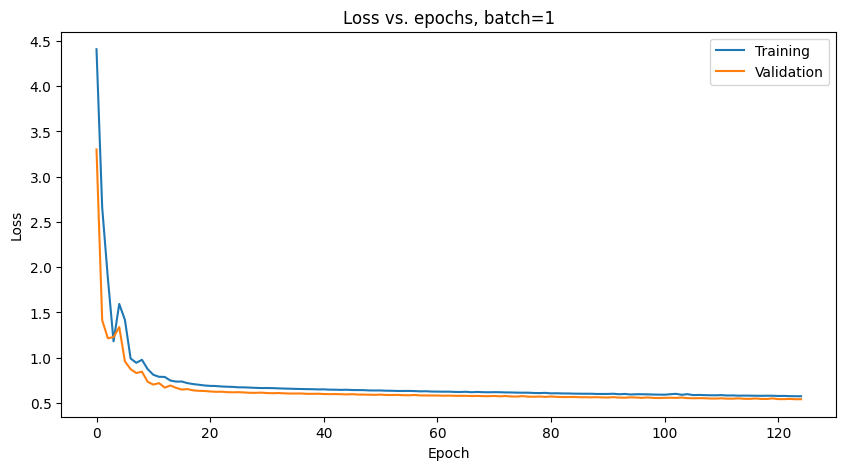

In [69]:
plt.figure(figsize=(10,5))
plt.plot(history.epoch, history.history['loss'])
plt.plot(history.epoch, history.history['val_loss'])
plt.title('Loss vs. epochs, batch=' +str(batch_size))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

##### Size =  Data

10. **Retrain for length of data batch size**

In [70]:
### START CODE HERE ###
model4 = build_model()
history = fit_model(model4, X_train, y_train, X_test, y_test, len(X_train))
###### END CODE HERE

Epoch 1/125


1/1 - 0s - loss: 2.2071 - accuracy: 0.3040 - val_loss: 2.2479 - val_accuracy: 0.2540 - 451ms/epoch - 451ms/step
Epoch 2/125
1/1 - 0s - loss: 2.1228 - accuracy: 0.3080 - val_loss: 2.1197 - val_accuracy: 0.3040 - 26ms/epoch - 26ms/step
Epoch 3/125
1/1 - 0s - loss: 2.0133 - accuracy: 0.3340 - val_loss: 2.0139 - val_accuracy: 0.3400 - 32ms/epoch - 32ms/step
Epoch 4/125
1/1 - 0s - loss: 1.9341 - accuracy: 0.3800 - val_loss: 1.9393 - val_accuracy: 0.3780 - 29ms/epoch - 29ms/step
Epoch 5/125
1/1 - 0s - loss: 1.8864 - accuracy: 0.3780 - val_loss: 1.8676 - val_accuracy: 0.3720 - 31ms/epoch - 31ms/step
Epoch 6/125
1/1 - 0s - loss: 1.8376 - accuracy: 0.3880 - val_loss: 1.7745 - val_accuracy: 0.3720 - 32ms/epoch - 32ms/step
Epoch 7/125
1/1 - 0s - loss: 1.7630 - accuracy: 0.3820 - val_loss: 1.6535 - val_accuracy: 0.3740 - 28ms/epoch - 28ms/step
Epoch 8/125
1/1 - 0s - loss: 1.6556 - accuracy: 0.3820 - val_loss: 1.5129 - val_accuracy: 0.3860 - 28ms/epoch - 28ms/step
Epoch 9/125
1/1 - 0s - loss: 1.523

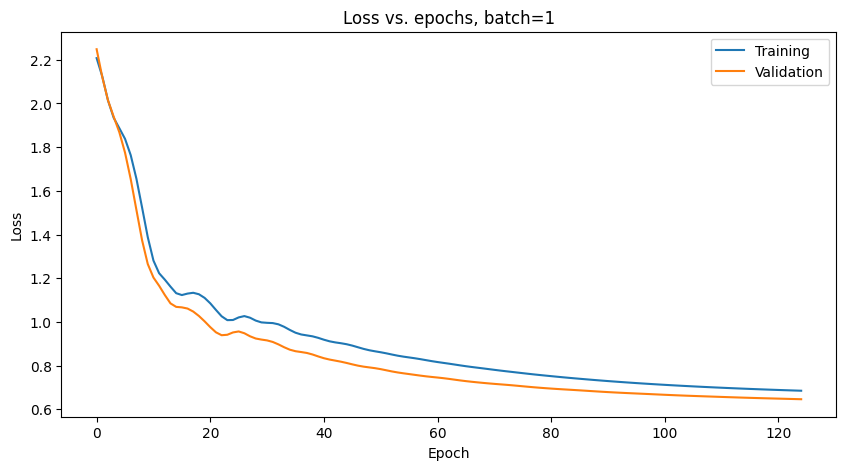

In [71]:
plt.figure(figsize=(10,5))
plt.plot(history.epoch, history.history['loss'])
plt.plot(history.epoch, history.history['val_loss'])
plt.title('Loss vs. epochs, batch=' +str(batch_size))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

10. **What effect does changing batch size have on learning in terms of convergence and fluctuations?**

**Answer:**
Larger batch sizes result in faster convergence. This is because with larger batches, you're updating the model's weights less frequently, and each update is based on a more stable estimate of the gradient but may needs more training epochs. Smaller batch sizes can introduce more randomness and fluctuations in the training process. The updates to the model's weights are based on a small subset of the data, which can result in noisy gradients and parameter updates. but small batch sizes can potentially lead to better generalization. With smaller batches, the model sees more diverse examples during each epoch.


#### Learning Rate

batch size 64

- **Use same code for build_model above, add an argument learning rate to change learning rate of optmizer**

In [72]:
def build_model(lr):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(50, activation='relu', kernel_initializer='he_uniform', input_shape=(2,)))
    model.add(tf.keras.layers.Dense(3, activation='softmax'))
    sgd = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

##### LR =  0.00001

10. **Retrain for 0.00001 LR**

In [81]:
### START CODE HERE ### ()
lr = 0.00001
model5 = build_model(lr)
history = fit_model(model5, X_train, y_train, X_test, y_test, 64)

Epoch 1/125


8/8 - 0s - loss: 4.4493 - accuracy: 0.3820 - val_loss: 4.0314 - val_accuracy: 0.4080 - 487ms/epoch - 61ms/step
Epoch 2/125
8/8 - 0s - loss: 4.1561 - accuracy: 0.3780 - val_loss: 3.6782 - val_accuracy: 0.4020 - 46ms/epoch - 6ms/step
Epoch 3/125
8/8 - 0s - loss: 3.7494 - accuracy: 0.3740 - val_loss: 3.2717 - val_accuracy: 0.3960 - 54ms/epoch - 7ms/step
Epoch 4/125
8/8 - 0s - loss: 3.3287 - accuracy: 0.3780 - val_loss: 2.8713 - val_accuracy: 0.3960 - 56ms/epoch - 7ms/step
Epoch 5/125
8/8 - 0s - loss: 2.9148 - accuracy: 0.3740 - val_loss: 2.5321 - val_accuracy: 0.4320 - 57ms/epoch - 7ms/step
Epoch 6/125
8/8 - 0s - loss: 2.5794 - accuracy: 0.3860 - val_loss: 2.2531 - val_accuracy: 0.4580 - 52ms/epoch - 6ms/step
Epoch 7/125
8/8 - 0s - loss: 2.2937 - accuracy: 0.4040 - val_loss: 2.0492 - val_accuracy: 0.4640 - 449ms/epoch - 56ms/step
Epoch 8/125
8/8 - 0s - loss: 2.0949 - accuracy: 0.4180 - val_loss: 1.8993 - val_accuracy: 0.4800 - 57ms/epoch - 7ms/step
Epoch 9/125
8/8 - 0s - loss: 1.9587 - ac

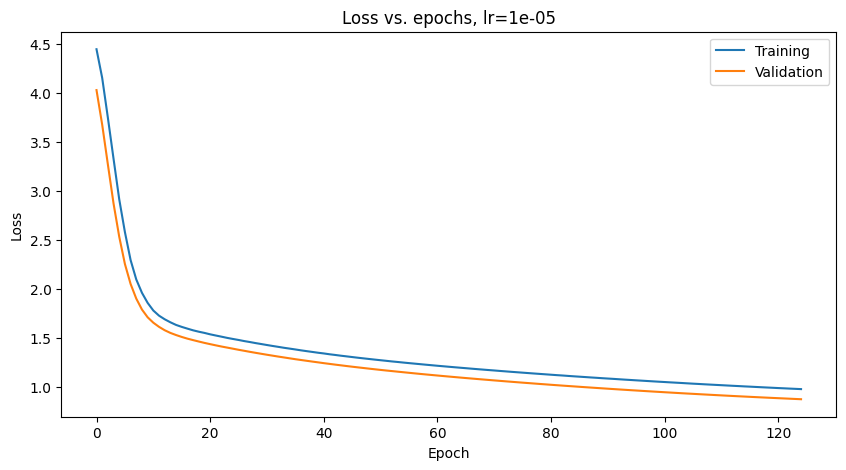

In [82]:
plt.figure(figsize=(10,5))
plt.plot(history.epoch, history.history['loss'])
plt.plot(history.epoch, history.history['val_loss'])
plt.title('Loss vs. epochs, lr=' +str(lr))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

##### LR =  0.001

10. **Retrain for 0.001 LR**

In [77]:
### START CODE HERE ### ()
lr = 0.001
model5 = build_model(lr)
history = fit_model(model5, X_train, y_train, X_test, y_test, 64)

Epoch 1/125
8/8 - 0s - loss: 3.7447 - accuracy: 0.3820 - val_loss: 2.1521 - val_accuracy: 0.4380 - 451ms/epoch - 56ms/step
Epoch 2/125
8/8 - 0s - loss: 2.0900 - accuracy: 0.4760 - val_loss: 2.0611 - val_accuracy: 0.4540 - 43ms/epoch - 5ms/step
Epoch 3/125
8/8 - 0s - loss: 1.8135 - accuracy: 0.4940 - val_loss: 1.5344 - val_accuracy: 0.5800 - 44ms/epoch - 6ms/step
Epoch 4/125
8/8 - 0s - loss: 1.3902 - accuracy: 0.5860 - val_loss: 1.1057 - val_accuracy: 0.6480 - 46ms/epoch - 6ms/step
Epoch 5/125
8/8 - 0s - loss: 1.0223 - accuracy: 0.6380 - val_loss: 0.9371 - val_accuracy: 0.6760 - 48ms/epoch - 6ms/step
Epoch 6/125
8/8 - 0s - loss: 0.9699 - accuracy: 0.6360 - val_loss: 0.9390 - val_accuracy: 0.6720 - 46ms/epoch - 6ms/step
Epoch 7/125
8/8 - 0s - loss: 0.9293 - accuracy: 0.6320 - val_loss: 0.8554 - val_accuracy: 0.6840 - 46ms/epoch - 6ms/step
Epoch 8/125
8/8 - 0s - loss: 0.8868 - accuracy: 0.6440 - val_loss: 0.8275 - val_accuracy: 0.6860 - 46ms/epoch - 6ms/step
Epoch 9/125
8/8 - 0s - loss: 0

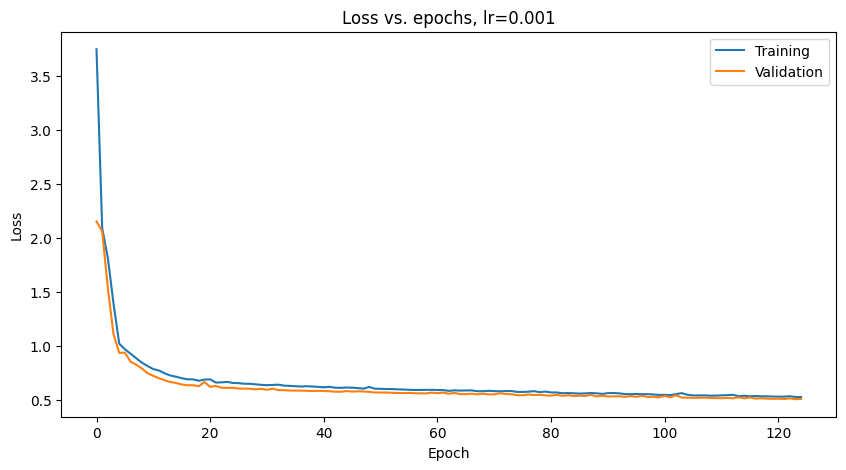

In [78]:
plt.figure(figsize=(10,5))
plt.plot(history.epoch, history.history['loss'])
plt.plot(history.epoch, history.history['val_loss'])
plt.title('Loss vs. epochs, lr=' +str(lr))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

##### LR =  0.1

10. **Retrain for 0.1 LR**

In [79]:
### START CODE HERE ### ()
lr = 0.1
model5 = build_model(lr)
history = fit_model(model5, X_train, y_train, X_test, y_test, 64)

Epoch 1/125
8/8 - 1s - loss: 9.7469 - accuracy: 0.3900 - val_loss: 4.4184 - val_accuracy: 0.4820 - 507ms/epoch - 63ms/step
Epoch 2/125
8/8 - 0s - loss: 5.6642 - accuracy: 0.4360 - val_loss: 5.6729 - val_accuracy: 0.4300 - 48ms/epoch - 6ms/step
Epoch 3/125
8/8 - 0s - loss: 2.9704 - accuracy: 0.4340 - val_loss: 1.3770 - val_accuracy: 0.5560 - 48ms/epoch - 6ms/step
Epoch 4/125
8/8 - 0s - loss: 1.3649 - accuracy: 0.5420 - val_loss: 1.4249 - val_accuracy: 0.5800 - 49ms/epoch - 6ms/step
Epoch 5/125
8/8 - 0s - loss: 1.3271 - accuracy: 0.5480 - val_loss: 1.2299 - val_accuracy: 0.5960 - 47ms/epoch - 6ms/step
Epoch 6/125
8/8 - 0s - loss: 1.0594 - accuracy: 0.6360 - val_loss: 0.8996 - val_accuracy: 0.8120 - 51ms/epoch - 6ms/step
Epoch 7/125
8/8 - 0s - loss: 0.8933 - accuracy: 0.7540 - val_loss: 0.7967 - val_accuracy: 0.7660 - 49ms/epoch - 6ms/step
Epoch 8/125
8/8 - 0s - loss: 0.7965 - accuracy: 0.7380 - val_loss: 0.7116 - val_accuracy: 0.7780 - 50ms/epoch - 6ms/step
Epoch 9/125
8/8 - 0s - loss: 0

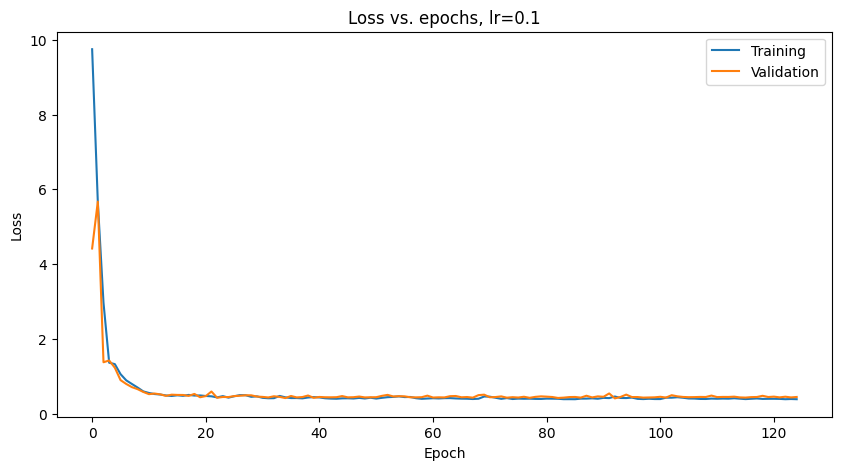

In [80]:
plt.figure(figsize=(10,5))
plt.plot(history.epoch, history.history['loss'])
plt.plot(history.epoch, history.history['val_loss'])
plt.title('Loss vs. epochs, lr=' +str(lr))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

10. **What effect does changing learning rate have on learning?**






**Answer:** A higher learning rate can lead to faster convergence but it cause the training process to oscillate more. A smaller learning rate tends to result in a more stable training process

**Questions**

1. Mention 1 advantage of a computational graph?

**Answer:** One advantage of a computational graph is automatic differentiation. Computational graphs are used in automatic differentiation frameworks, such as TensorFlow and PyTorch, which enable the efficient calculation of gradients or derivatives of a complex mathematical function with respect to its input variables.

2. Mention two ways to input data for training using TensorFlow if the data resides on disk

**Answer:**
1. using `tf.data` API we can easily load data from local disk

2. we can implement custom data generators that read and preprocess data from disk and feed it into our model using `tf.keras.utils.Sequence`